
In this notebook supervised learning techniques are used to classify spectra for stars. Spectra are very detailed colors. Instead of 3 colors like in RGB they can have much more. In our case they are 3072 in the raw data. Like images they have numeric values. Here they are floats, thus the features are a vector 3072 floats. The spectra are normalized by fitting a linear function to a range which is does not have strong features. 

In [59]:
#basic libraries
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#We mainly use xgboost
from xgboost import XGBClassifier
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#logistic regression
from sklearn.linear_model import LogisticRegression



#Astrop.io is needed to read the files with the astronomical features. 
from astropy.io import fits

Below we load the feature and label data.

In [10]:
#directory of the data
path='/home/tobias/ml-testing/spectra-ML/met-cal-22/'
#feature data
x=np.loadtxt(path+'feature_classification.txt')
print(f"shape of feature data is {np.shape(x)}")
print(f"There are {np.shape(x)[1]} examples with each {np.shape(x)[0]} features")
#includes besides main labels also other data
yplus=np.loadtxt(path+'label_classification.txt')
print(f"shape of label data is {np.shape(yplus)}")
#there are three labels values
print(f"number of 0 labels {np.count_nonzero(yplus[0,:]==0)}")
print(f"number of 1 labels {np.count_nonzero(yplus[0,:]==1)}")
print(f"number of 2 labels {np.count_nonzero(yplus[0,:]==2)}")

shape of feature data is (3072, 3773)
There are 3773 examples with each 3072 features
shape of label data is (5, 3773)
number of 0 labels 57
number of 1 labels 3661
number of 2 labels 55


There are three exclusive labels. 1 and 2 describe different recognisable classes. 0 is for all for which the class cannot be identified.  We now look on the features to exclude some of them. 

shape of general features (13, 4253)
number of late labels 4166
number of early labels 32
number of unclassified labels 55


(3072, 1, 57)


Text(0, 0.5, 'feature value')

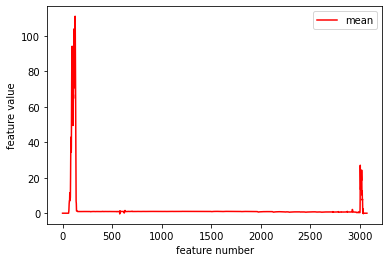

In [41]:
#separate class for statistic
class0=x[:,np.where(yplus[0,:]==0)]
class1=x[:,np.where(yplus[0,:]==1)]
class2=x[:,np.where(yplus[0,:]==2)]
print(np.shape(class0))
res=np.zeros((15,3072))
cg=np.shape(x)[1]
for i in range(3072):
    res[0,i]=i
    res[1,i]= np.count_nonzero(x[i]==0)/cg
    res[2,i]=1.92499995231628+i*0.000187174489838071  #wavelength in micron the physical meaning of the labels 
    res[3,i]=np.mean(x[i]) #statistic of all
    res[4,i]=np.median(x[i])    
    res[5,i]=np.std(x[i])  
    res[6,i]=np.mean(class0[i]) #statistic of class0
    res[7,i]=np.median(class0[i])    
    res[8,i]=np.std(class0[i])    
    res[9,i]=np.mean(class1[i]) #statistic of class0
    res[10,i]=np.median(class1[i])    
    res[11,i]=np.std(class1[i])
    res[12,i]=np.mean(class2[i]) #statistic of class0
    res[13,i]=np.median(class2[i])    
    res[14,i]=np.std(class2[i])     
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.legend(loc="best")
#plt.xlim(1.95,2.48)
#plt.ylim(0.3,1.4)
plt.xlabel("feature number")
plt.ylabel("feature value")

Some of most extreme values have strong peaks partly. WE now zoom in them. 

Text(0, 0.5, 'feature value')

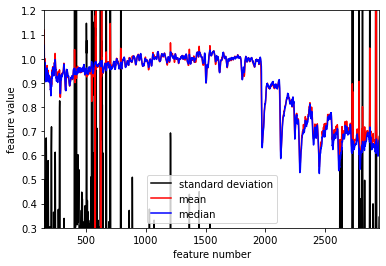

In [31]:
plt.plot(res[0],res[5],'-',color='black',label='standard deviation') 
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.plot(res[0],res[4],'-',color='blue',label='median') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.3,1.2)
plt.xlabel("feature number")
plt.ylabel("feature value")

Text(0, 0.5, 'standard deviation')

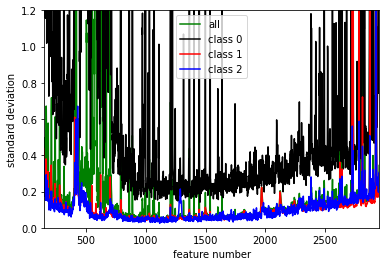

In [38]:
plt.plot(res[0],res[5],'-',color='green',label='all') 
plt.plot(res[0],res[8],'-',color='black',label='class 0') 
plt.plot(res[0],res[11],'-',color='red',label='class 1') 
plt.plot(res[0],res[14],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.0,1.2)
plt.xlabel("feature number")
plt.ylabel("standard deviation")

Text(0, 0.5, 'median')

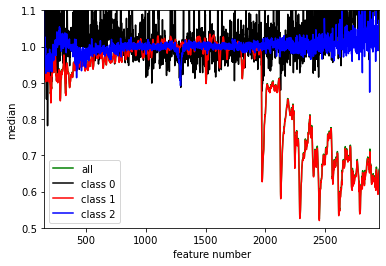

In [44]:
plt.plot(res[0],res[7],'-',color='black',label='class 0') 
plt.plot(res[0],res[10],'-',color='red',label='class 1') 
plt.plot(res[0],res[13],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("median")

For the analysis we avoid the feature ranges with string spikes. We select between 800 and 2700.

In [51]:
low=800
high=2700
#features
xsel=x[low:high]
#statistic
ressel=res[:,low:high] 

Classes in the selected range. 

Text(0, 0.5, 'average')

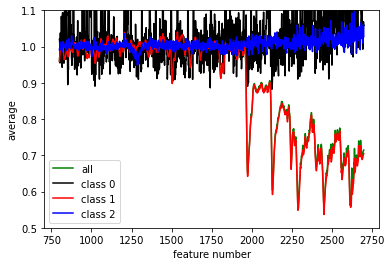

In [55]:
plt.plot(ressel[0],ressel[6],'-',color='black',label='class 0') 
plt.plot(ressel[0],ressel[9],'-',color='red',label='class 1') 
plt.plot(ressel[0],ressel[12],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")

There are no very narrow positive spikes visible in class 1 and 2. Class 0 has some as expected, since it consists of not so good data.

A relative large test set is used because not many sources are in the rare classes.

In [126]:
xsel_train, xsel_test, y_train, y_test, yplus_train,yplus_test= train_test_split(np.transpose(xsel), yplus[0], yplus.T, test_size=0.3, random_state=42)
print(f"shape of training features {np.shape(xsel_train)}")
print(f"shape of training labels {np.shape(y_train)}")

shape of training features (2641, 1900)
shape of training labels (2641,)


We start with logistic regression.

In [60]:
lr1 = LogisticRegression('none',max_iter=200)
lr1.fit(xsel_train,y_train)

LogisticRegression(max_iter=200, penalty='none')

In [61]:
restr=lr1.predict_proba(xsel_train)  #probabilities
reste=lr1.predict_proba(xsel_test)
restrc=lr1.predict(xsel_train)  #classes
restec=lr1.predict(xsel_test)


[[  37    0    0]
 [   0 2572    0]
 [   0    0   32]]


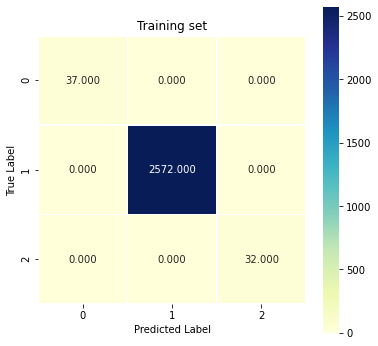

In [62]:
cm_nbtrain = confusion_matrix(y_train, restrc)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

As visisble in the confusion matrix, the model predicts the labels perfectly for the training label. In contrast 
in the test case there are a number of miss classified sources. Thus there is overfitting. 

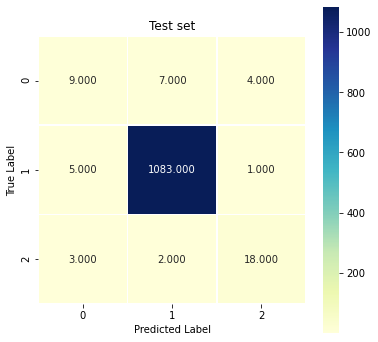

In [63]:
cm_nbtest = confusion_matrix(y_test, restec)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

To be quantitaive in decding how good the model is we use the F1 measure of each class. We use class separatly because
as expected the rare classes seem more difficult. 

In [87]:
#gets f1 score for a specified  from confusing matrix 
def fmeas(conf_matrix,x):
    if np.sum(conf_matrix[:,x])==0:
        prec=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
    if np.sum(conf_matrix[x])==0:
        rec=0
    else:
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])

    if prec==0 and rec==0:
        f1=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])
        f1=(2*prec*rec)/(prec+rec)
    return f1

In [69]:
print(f"F1 score (test, class 0) {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 1) {round(fmeas(cm_nbtest,1),3)}")
print(f"F1 score (test, class 2) {round(fmeas(cm_nbtest,2),3)}")

F1 score (test, class 0) 0.486
F1 score (test, class 1) 0.993
F1 score (test, class 2) 0.783


The F1 is worth for class 2 and even worse for class 0. That class 0 is most difficult is to be expected, because it is a left over class.

To reduce overfitting, we now add regularization. We explore a range of regularzations parameters.


In [71]:
#regularzaition in steps of factor 2
regs=np.zeros((7,13))
regs[0,0]=1
regs[0,1]=0.5
regs[0,2]=0.22
regs[0,3]=0.1
regs[0,4]=0.05
regs[0,5]=0.022
regs[0,6]=0.01
regs[0,7]=0.005
regs[0,8]=0.0022
regs[0,9]=0.001
regs[0,10]=0.0005
regs[0,11]=0.00022
regs[0,12]=0.0001
for i in range(np.shape(regs)[1]):
    print(f"regulurization {regs[0,i]}")
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs[0,i])
    lr3.fit(xsel_train,y_train)
    restrc3=lr3.predict(xsel_train)  
    restec3=lr3.predict(xsel_test)
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    regs[1,i]=fmeas(cm_nbtest3,0)
    regs[2,i]=fmeas(cm_nbtest3,2)
    regs[3,i]=np.mean(regs[1:3,i])
    regs[4,i]=fmeas(cm_nbtrain3,0)
    regs[5,i]=fmeas(cm_nbtrain3,2)
    regs[6,i]=np.mean(regs[4:6,i])  

regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


F1 score (test, class 0) no regulurization 0.486
F1 score (test, class 2) no regulurization 0.783
F1 score (test, class 0) best regulurization 0.5
F1 score (test, class 2) best regulurization 0.836


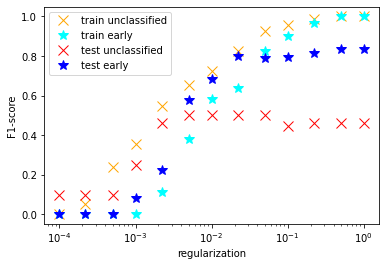

In [79]:
plt.plot(regs[0],regs[4],'x',color='orange',ms=10,label='train unclassified') 
plt.plot(regs[0],regs[5],'*',color='cyan',ms=10,label='train early') 
plt.plot(regs[0],regs[1],'x',color='red',ms=10,label='test unclassified') 
plt.plot(regs[0],regs[2],'*',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
print(f"F1 score (test, class 0) no regulurization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regulurization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regulurization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regulurization {round(max(regs[2]),3)}")

Regularization improves only a little for test, the best F1 score a very similar to the F1 score with no regularization. Likely the data is to conlicated for logistic regression. (Include example of range for early)

We start with using the standard seetings of XCB classifier.

In [80]:
modelx1 = XGBClassifier()
modelx1.fit(xsel_train, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Getting the predictions of test and training.

In [81]:
y_pred_train = modelx1.predict(xsel_train)
y_pred_test = modelx1.predict(xsel_test)


We look again on the confusion matrixes.

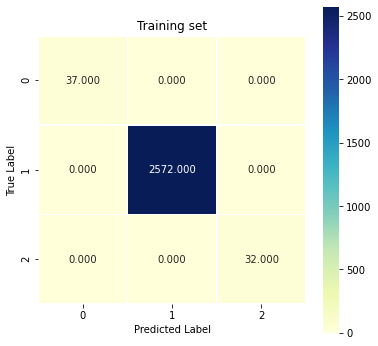

In [83]:
cm_nbtrainx1 = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainx1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

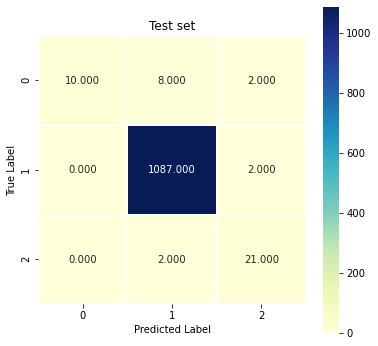

In [84]:
cm_nbtestx1 = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestx1, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [89]:
print(f"precision of early in training: {cm_nbtrainx1[2,2]/np.sum(cm_nbtrainx1[:,2])}")
print(f"recall of early in training: {cm_nbtrainx1[2,2]/np.sum(cm_nbtrainx1[2])}")
print(f"precision of unclassified in training: {cm_nbtrainx1[0,0]/np.sum(cm_nbtrainx1[:,0])}")
print(f"recall of unclassified in training: {cm_nbtrainx1[0,0]/np.sum(cm_nbtrainx1[0])}")

print(f"precision of early in test: {cm_nbtestx1[2,2]/np.sum(cm_nbtestx1[:,2])}")
print(f"recall of early in test: {cm_nbtestx1[2,2]/np.sum(cm_nbtestx1[2])}")
print(f"precision of unclassified in test: {cm_nbtestx1[0,0]/np.sum(cm_nbtestx1[:,0])}")
print(f"recall of unclassified in test: {cm_nbtestx1[0,0]/np.sum(cm_nbtestx1[0])}")

print(f"F1 score (test, class 0) logistic regression {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) logistic regression {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) xgboost {round(fmeas(cm_nbtestx1,0),3)}")
print(f"F1 score (test, class 2) xgboost {round(fmeas(cm_nbtestx1,2),3)}")

precision of early in training: 1.0
recall of early in training: 1.0
precision of unclassified in training: 1.0
recall of unclassified in training: 1.0
precision of early in test: 0.84
recall of early in test: 0.9130434782608695
precision of unclassified in test: 1.0
recall of unclassified in test: 0.5
F1 score (test, class 0) logistic regression 0.486
F1 score (test, class 2) logistic regression 0.783
F1 score (test, class 0) xgboost 0.667
F1 score (test, class 2) xgboost 0.875


In training the labels are perfectly predicted. In the test also class 1 is also very good classified, only two truly late or predicted as different. In contrast, the prediction is less good for class 2 and even more for class 0. Especially, recall of unclassified is bad because the unclassified stars are wrongly classified because the class unclassfied as found by xgb is too narrow. That late is easiest is expected because late is the most abundant and most homogen class. Overall, the difference between test and tarining shows that there is overfitting. 
There is clear improvement compared to logistic regression.  

For counterimng overfitting the model needs to be changed. Given the few test samples best is a way with not too many free parameters. Therefore, I select subsample where there is only one parameter. 

In [90]:
modelx2 = XGBClassifier(subsample=0.5)
modelx2.fit(xsel_train, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [91]:
y2_pred_train = modelx2.predict(xsel_train)
y2_pred_test = modelx2.predict(xsel_test)

There are still all right in the training set and clearly less in test set. There is some improvemnt in the test set, especially for the unclassified.

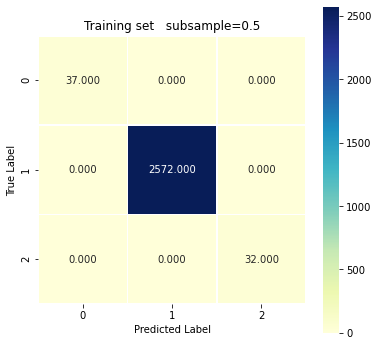

In [92]:
cm_nbtrainx2 = confusion_matrix(y_train, y2_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrainx2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set   subsample=0.5'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

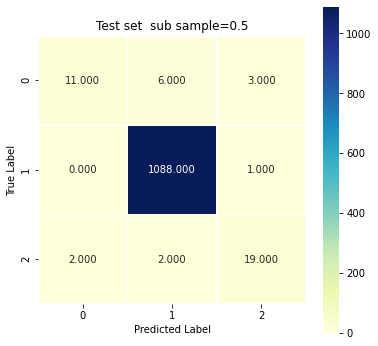

In [93]:
cm_nbtestx2 = confusion_matrix(y_test, y2_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtestx2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set  sub sample=0.5'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [97]:
print(f"precision of early in training: {cm_nbtrainx2[2,2]/np.sum(cm_nbtrainx2[:,2])}")
print(f"recall of early in training: {cm_nbtrainx2[2,2]/np.sum(cm_nbtrainx2[2])}")
print(f"precision of unclassified in training: {cm_nbtrainx2[0,0]/np.sum(cm_nbtrainx2[:,0])}")
print(f"recall of unclassified in training: {cm_nbtrainx2[0,0]/np.sum(cm_nbtrainx2[0])}")

print(f"precision of early in test: {cm_nbtestx2[2,2]/np.sum(cm_nbtestx2[:,2])}")
print(f"recall of early in test: {cm_nbtestx2[2,2]/np.sum(cm_nbtestx2[2])}")
print(f"precision of unclassified in test: {cm_nbtestx2[0,0]/np.sum(cm_nbtestx2[:,0])}")
print(f"recall of unclassified in test: {cm_nbtestx2[0,0]/np.sum(cm_nbtestx2[0])}")

print(f"F1 score (test, class 0) xgboost full sample {round(fmeas(cm_nbtestx1,0),3)}")
print(f"F1 score (test, class 2) xgboost full sample {round(fmeas(cm_nbtestx1,2),3)}")
print(f"F1 score (test, class 0) xgboost sample=0.5 {round(fmeas(cm_nbtestx2,0),3)}")
print(f"F1 score (test, class 2) xgboost sample=0.5 {round(fmeas(cm_nbtestx2,2),3)}")

precision of early in training: 1.0
recall of early in training: 1.0
precision of unclassified in training: 1.0
recall of unclassified in training: 1.0
precision of early in test: 0.8260869565217391
recall of early in test: 0.8260869565217391
precision of unclassified in test: 0.8461538461538461
recall of unclassified in test: 0.55
F1 score (test, class 0) xgboost full sample 0.667
F1 score (test, class 2) xgboost full sample 0.875
F1 score (test, class 0) xgboost sample=0.5 0.667
F1 score (test, class 2) xgboost sample=0.5 0.826


To explore the subsample paramter more we run more models systematically.

In [99]:
#In ress the are summariyed using the F1 score. 
#First the f1 score of the current models early and unclassufied and their average 
ress=np.zeros((7,10))
ress[0,0]=1.0
ress[1,0]=fmeas(cm_nbtrainx1,int(2))
ress[2,0]=fmeas(cm_nbtrainx1,int(0))
ress[3,0]=(ress[1,0]+ress[2,0])/2
ress[4,0]=fmeas(cm_nbtestx1,int(2))
ress[5,0]=fmeas(cm_nbtestx1,int(0))
ress[6,0]=(ress[4,0]+ress[5,0])/2
ress[0,1]=0.5
ress[1,1]=fmeas(cm_nbtrainx2,int(2))
ress[2,1]=fmeas(cm_nbtrainx2,int(0))
ress[3,1]=(ress[1,1]+ress[2,1])/2
ress[4,1]=fmeas(cm_nbtestx2,int(2))
ress[5,1]=fmeas(cm_nbtestx2,int(0))
ress[6,1]=(ress[4,1]+ress[5,1])/2
#defining the further subsample values
ress[0,2]=0.33
ress[0,3]=0.2
ress[0,4]=0.14
ress[0,5]=0.1
ress[0,6]=0.07
ress[0,7]=0.05
ress[0,8]=0.04
ress[0,9]=0.03

In [100]:
#running for more subsample values
for i in range(2,10):
    print(i)
    print(f"subsample of {ress[0,i]}")
    model3 = XGBClassifier(subsample=ress[0,i])  
    model3.fit(xsel_train,y_train)
    y3_pred_train = model3.predict(xsel_train)
    y3_pred_test = model3.predict(xsel_test)
    cm_nbtrain3 = confusion_matrix(y_train, y3_pred_train)
    cm_nbtest3 = confusion_matrix(y_test, y3_pred_test)
    ress[1,i]=fmeas(cm_nbtrain3,int(2))
    ress[2,i]=fmeas(cm_nbtrain3,int(0))
    ress[3,i]=(ress[1,i]+ress[2,i])/2
    ress[4,i]=fmeas(cm_nbtest3,int(2))
    ress[5,i]=fmeas(cm_nbtest3,int(0))
    ress[6,i]=(ress[4,i]+ress[5,i])/2

2
subsample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3
subsample of 0.2
[15:46:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


4
subsample of 0.14
[15:46:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


5
subsample of 0.1
[15:46:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


6
subsample of 0.07
[15:46:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


7
subsample of 0.05
[15:46:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


8
subsample of 0.04
[15:46:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


9
subsample of 0.03
[15:46:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In training the score decreases continiously wuth subsample size. In the test sample the evolution of the F1-score is usually smaller overall and it is noisy with up and downs. The optimum values is different for unclassified and early. Overall the score is rather flat. Small subsample perform worse but including0.07 and bove there is no clear preferance, all achive about 0.73 to 0.82 as F1-score average over the two rare classes.

[0.77083333 0.74637681 0.81713555 0.79504505 0.78119658 0.72782705
 0.77960526 0.69886364 0.70559006 0.5042735 ]
[1.   0.5  0.33 0.2  0.14 0.1  0.07 0.05 0.04 0.03]


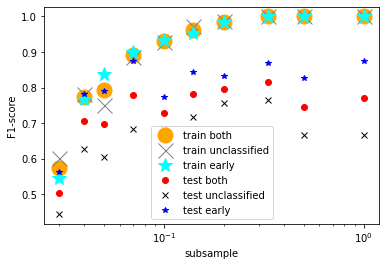

In [104]:
plt.plot(ress[0],ress[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress[0],ress[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress[0],ress[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress[0],ress[6],'o',color='red',label='test both') 
plt.plot(ress[0],ress[5],'x',color='black',label='test unclassified') 
plt.plot(ress[0],ress[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
print(ress[6])
print(ress[0])

Using different weights for the classes should improve performance for rare classes.

In [106]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
print(np.min(classes_weights))
print(np.max(classes_weights))

0.34227579056505963
27.510416666666668


In [107]:
xgb_classifier8 = xgb.XGBClassifier(subsample=0.5)
xgb_classifier8.fit(xsel_train, y_train, sample_weight=classes_weights)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [108]:
y8_pred_train = xgb_classifier8.predict(xsel_train)
y8_pred_test = xgb_classifier8.predict(xsel_test)

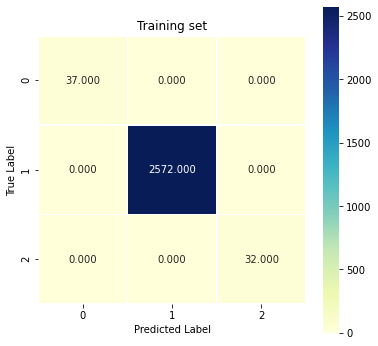

In [109]:
cm_nbtrain8 = confusion_matrix(y_train, y8_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain8, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

[[-1  1  0]
 [ 3 -4  1]
 [-2 -2  4]]
F1 score with w/o weights class 0: 0.667
F1 score with w/o weights class 2: 0.826
F1 score with weights class 0: 0.606
F1 score with weights class 2: 0.902


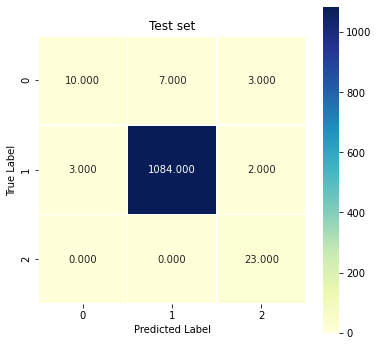

In [115]:
cm_nbtest8 = confusion_matrix(y_test, y8_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest8, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');
print(cm_nbtest8-cm_nbtestx2)  
print(f"F1 score with w/o weights class 0: {round(fmeas(cm_nbtestx2,0),3)}")
print(f"F1 score with w/o weights class 2: {round(fmeas(cm_nbtestx2,2),3)}")
print(f"F1 score with weights class 0: {round(fmeas(cm_nbtest8,0),3)}")
print(f"F1 score with weights class 2: {round(fmeas(cm_nbtest8,2),3)}")

Using weights in the fitting improves performance in the measures for the rare classes overall but not by by much because the number of corrected unclassified decreases. 

We now run weighted for all the same subsamples fraction as before. 

In [116]:
ress2=np.zeros((7,10))
ress2[0,:]=ress[0,:]
print(ress2[0,:])

[1.   0.5  0.33 0.2  0.14 0.1  0.07 0.05 0.04 0.03]


In [117]:
for i in range(10):
    print(f"sub sample of {ress2[0,i]}")
    xgb_classifier9 = xgb.XGBClassifier(subsample=ress2[0,i])
    xgb_classifier9.fit(xsel_train, y_train, sample_weight=classes_weights)
    y9_pred_train = xgb_classifier9.predict(xsel_train)
    y9_pred_test = xgb_classifier9.predict(xsel_test)
    cm_nbtrain9 = confusion_matrix(y_train, y9_pred_train)
    cm_nbtest9 = confusion_matrix(y_test, y9_pred_test)
    ress2[1,i]=fmeas(cm_nbtrain9,int(2))
    ress2[2,i]=fmeas(cm_nbtrain9,int(0))
    ress2[3,i]=(ress2[1,i]+ress2[2,i])/2
    ress2[4,i]=fmeas(cm_nbtest9,int(2))
    ress2[5,i]=fmeas(cm_nbtest9,int(0))
    ress2[6,i]=(ress2[4,i]+ress2[5,i])/2

sub sample of 1.0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.5


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.2
[16:12:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.14
[16:12:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.1
[16:12:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.07
[16:12:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.05
[16:12:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.04
[16:12:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


sub sample of 0.03
[16:12:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Sub sample of 0.2 performs best for unclassified and is also close to best for early. In principle it still overfits the training data but when that is not anymore the care (below subsample of 0.1), the performance on the test data is also worse.

Text(0.5, 1.0, 'weighted fits')

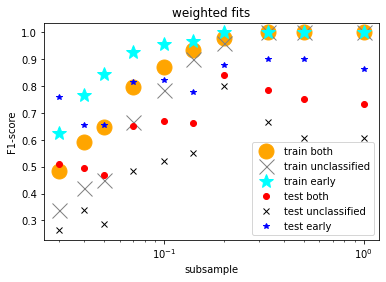

In [118]:
plt.plot(ress2[0],ress2[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress2[0],ress2[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress2[0],ress2[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress2[0],ress2[6],'o',color='red',label='test both') 
plt.plot(ress2[0],ress2[5],'x',color='black',label='test unclassified') 
plt.plot(ress2[0],ress2[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("weighted fits")

Text(0, 0.5, 'test F1-score')

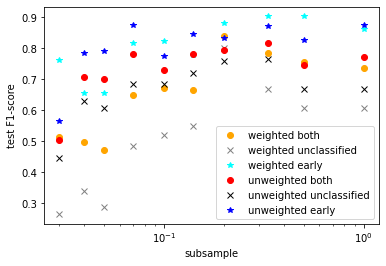

In [119]:
plt.plot(ress2[0],ress2[6],'o',color='orange',label='weighted both') 
plt.plot(ress2[0],ress2[5],'x',color='gray',label='weighted unclassified') 
plt.plot(ress2[0],ress2[4],'*',color='cyan',label='weighted early') 
plt.plot(ress[0],ress[6],'o',color='red',label='unweighted both') 
plt.plot(ress[0],ress[5],'x',color='black',label='unweighted unclassified') 
plt.plot(ress[0],ress[4],'*',color='blue',label='unweighted early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("test F1-score")

Intrinsic noisy (random variation between neighboring features) clearly affects the data. It is a a main reason for unclassified classifications. XGB has likely difficult to recognize that because the sample of unclassfied is too small that it can recognize it from the data. Therefore now the noise is added as an additional feature. The noise is the standard deviation between the features and the features smoothed with a Gaussian of a width of 1 pixel over the wavelength range between 2.08 and 2.29 were the features are normalized.  

In [128]:
#the noise lvel is feature is currently in the general labels at 7
print(f"noise is {yplus[4]}")
#add noise to new feature vector
print(f"current feature shape of traing set is {np.shape(xsel_train)}")
#create new features
xsel_train2=np.zeros((np.shape(xsel_train)[0],np.shape(xsel_train)[1]+1))
xsel_test2=np.zeros((np.shape(xsel_test)[0],np.shape(xsel_test)[1]+1))
#copy old 
xsel_train2[:,0:np.shape(xsel_train)[1]]=xsel_train
xsel_test2[:,0:np.shape(xsel_test)[1]]=xsel_test
#add noise as feature
xsel_train2[:,np.shape(xsel_train)[1]]=yplus_train[:,4]
xsel_test2[:,np.shape(xsel_test)[1]]=yplus_test[:,4]

noise is [ 54.56041175  58.37582071  49.42498075 ...  51.15859649  93.74415085
 146.37331923]
current feature shape of traing set is (2641, 1900)


Fit with subsample of 0.5 as before. 

In [129]:
model10 = XGBClassifier(subsample=0.5)
model10.fit(xsel_train2, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [130]:
y10_pred_train = model10.predict(xsel_train2)
y10_pred_test = model10.predict(xsel_test2)

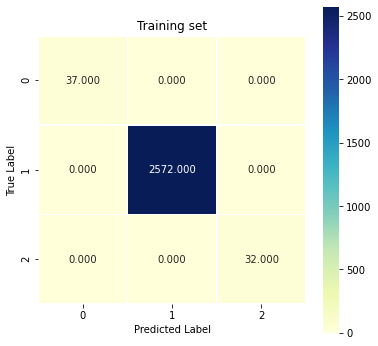

In [131]:
cm_nbtrain10 = confusion_matrix(y_train, y10_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain10, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

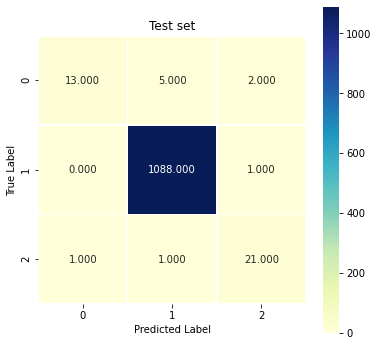

In [132]:
cm_nbtest10 = confusion_matrix(y_test, y10_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest10, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

The F1 score of early is on the same level as the best before. The one of unclassified is somewhat worse. However, we have not added weights here and also not tried subsample, thus the comparsion is not fair. 

In [135]:
print("all is for the test set")
print(f"F1-score unclassified {fmeas(cm_nbtest10,0)}")
print(f"best F1-score of unclassified before was {max(np.max(ress[5]),np.max(ress2[5]))}")
print(f"F1-score early {fmeas(cm_nbtest10,2)}")
print(f"best F1-score of early before was {max(np.max(ress[4]),np.max(ress2[4]))}")

all is for the test set
F1-score unclassified 0.7647058823529412
best F1-score of unclassified before was 0.8000000000000002
F1-score early 0.8936170212765957
best F1-score of early before was 0.9019607843137255
best F1-score of both was before was 0.8400000000000001


Now also adding weights to fit. 

In [136]:
xgb_classifier11 = xgb.XGBClassifier(subsample=0.5)
xgb_classifier11.fit(xsel_train2, y_train, sample_weight=classes_weights)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:29:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [137]:
y11_pred_train = xgb_classifier11.predict(xsel_train2)
y11_pred_test = xgb_classifier11.predict(xsel_test2)

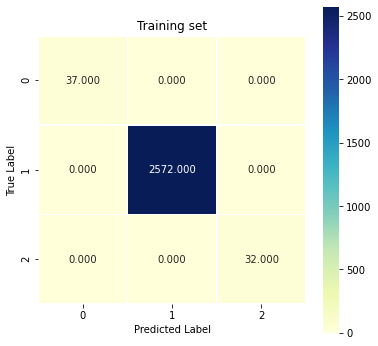

In [138]:
cm_nbtrain11 = confusion_matrix(y_train, y11_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain11, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

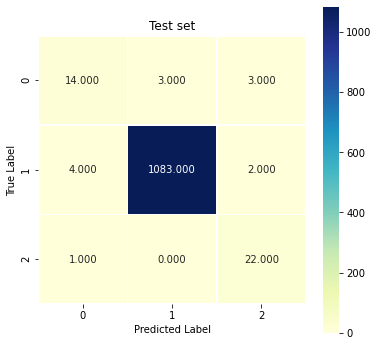

In [139]:
cm_nbtest11 = confusion_matrix(y_test, y11_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest11, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

With the weights the classification does not improve even for the rare classes. As expected there is also worse classification of the late labelled ones.

In [140]:
print("all is for the test set")
print(f"F1-score unclassified unweighted {fmeas(cm_nbtest10,0)}")
print(f"F1-score unclassified weighted {fmeas(cm_nbtest11,0)}")
print(f"F1-score early unweighted {fmeas(cm_nbtest10,2)}")
print(f"F1-score early weighted {fmeas(cm_nbtest11,2)}")

all is for the test set
F1-score unclassified unweighted 0.7647058823529412
F1-score unclassified weighted 0.717948717948718
F1-score early unweighted 0.8936170212765957
F1-score early weighted 0.8800000000000001


Now we run unweighted with the additional noise label for the same sub sample values as before. 

In [141]:
ress3=np.zeros((7,10))
ress3[0,:]=ress[0,:]
for i in range(10):
    print(f"subsample of {ress3[0,i]}")
    model3 = XGBClassifier(subsample=ress3[0,i])  
    model3.fit(xsel_train2,y_train)
    y3_pred_train = model3.predict(xsel_train2)
    y3_pred_test = model3.predict(xsel_test2)
    cm_nbtrain3 = confusion_matrix(y_train, y3_pred_train)
    cm_nbtest3 = confusion_matrix(y_test, y3_pred_test)
    ress3[1,i]=fmeas(cm_nbtrain3,int(2))
    ress3[2,i]=fmeas(cm_nbtrain3,int(0))
    ress3[3,i]=(ress3[1,i]+ress3[2,i])/2
    ress3[4,i]=fmeas(cm_nbtest3,int(2))
    ress3[5,i]=fmeas(cm_nbtest3,int(0))
    ress3[6,i]=(ress3[4,i]+ress3[5,i])/2

subsample of 1.0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.5


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.2
[16:30:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.14
[16:30:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.1
[16:30:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.07
[16:30:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.05
[16:30:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.04
[16:30:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


subsample of 0.03
[16:30:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Sub sample of 0.5 is clearly the best sub sample of all for the test set. The values for the others are rather similar besides of the lowest one for 0.03.

Text(0.5, 1.0, 'noise an additional label')

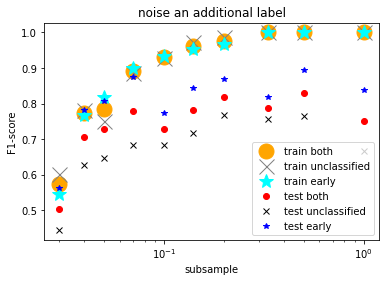

In [142]:
plt.plot(ress3[0],ress3[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress3[0],ress3[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress3[0],ress3[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress3[0],ress3[6],'o',color='red',label='test both') 
plt.plot(ress3[0],ress3[5],'x',color='black',label='test unclassified') 
plt.plot(ress3[0],ress3[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("noise an additional label")

In [106]:
#other ideas as real three paramters *not much sense just would for pseudo expertise, or use lamba single parameter

True

In [ ]:
#add neural network at least as trial 